# tsfresh Feature Engineering and Selection for Cambridge UK Weather Time Series

[tsfresh](https://tsfresh.readthedocs.io/) automated feature engineering and selection for time series analysis of Cambridge UK weather measurements taken at the [University computer lab weather station](https://www.cl.cam.ac.uk/research/dtg/weather/).

This notebook is being developed on [Google Colab](https://colab.research.google.com), primarily using [keras/tensorflow](https://www.tensorflow.org/guide/keras/sequential_model).  Initially I was most interested in short term temperature forecasts (less than 2 hours) but now mostly produce results up to 48 hours in the future for comparison with earlier [baselines](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb).

See my previous notebooks, web apps etc:
 * [Cambridge UK temperature forecast python notebooks](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks)
 * [Cambridge UK temperature forecast R models](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
 * [Bayesian optimisation of prophet temperature model](https://github.com/makeyourownmaker/BayesianProphet)
 * [Cambridge University Computer Laboratory weather station R shiny web app](https://github.com/makeyourownmaker/ComLabWeatherShiny)

The linked notebooks, web apps etc contain further details including:
 * data description
 * data cleaning and preparation
 * data exploration

In particular, see the notebooks:
 * [cammet_baselines_2021](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) including persistent, simple exponential smoothing, Holt Winter's exponential smoothing and vector autoregression
 * [keras_mlp_fcn_resnet_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb), which uses a streamlined version of data preparation from [Tensorflow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)
 * [lstm_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb) with stacked LSTMs, bidirectional LSTMs and ConvLSTM1D networks
 * [cnn_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cnn_time_series.ipynb) with Conv1D, multi-head Conv1D, Conv2D and Inception-style models
 * [encoder_decoder](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/encoder_decoder.ipynb) which includes autoencoder with attention, encoder decoder with teacher forcing, transformer with teacher forcing and padding, encoder only with MultiHeadAttention
 * [gradient_boosting](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/gradient_boosting.ipynb) gradient boosting for Cambridge UK weather time series

Most of the above repositories, notebooks, web apps etc were built on both less data and less thoroughly cleaned data.

---

Install [tsfresh](https://tsfresh.readthedocs.io/) which is currently unavailable on google colab.

**WARNING**: You will need to restart google colab after this install.

In [1]:
!pip install tsfresh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Install [darts](https://unit8co.github.io/darts/) because it is currently not available on google colab.

**WARNING**: You must restart the google colab runtime after this install.

In [2]:
#!pip install darts
# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.1 which is incompatible.

#!pip install "u8darts[torch]"
# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.1 which is incompatible.

!pip install "u8darts[pmdarima]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Load most of the other required packages.

In [3]:
import re
import sys
import json
import math
import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from itertools import product
from sklearn.preprocessing import StandardScaler

# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)

%matplotlib inline

env: PYTHONHASHSEED=0




## Import Data

The measurements are relatively noisy and there are usually several hundred missing values every year; often across multiple variables.
Observations have been extensively cleaned but may still have issues.  Interpolation and missing value imputation have been used to fill all missing values.  See the [cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning) in the [Cambridge Temperature Model repository](https://github.com/makeyourownmaker/CambridgeTemperatureModel) for details.  Observations start in August 2008 and end in September 2022 and occur every 30 mins.

Shape:


(247777, 33)


Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247777 entries, 2008-08-01 00:00:00 to 2022-09-19 00:00:00
Freq: 30T
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ds                247633 non-null  datetime64[ns]
 1   y                 247633 non-null  float64       
 2   y_seasonal        247633 non-null  float64       
 3   y_des             247633 non-null  float64       
 4   humidity          247633 non-null  float64       
 5   pressure          247633 non-null  float64       
 6   dew.point         247633 non-null  float64       
 7   mixing_ratio      247633 non-null  float64       
 8   ah                247633 non-null  float64       
 9   wind.x            247633 non-null  float64       
 10  wind.y            247633 non-null  float64       
 11  day.sin.1         247633 non-null  float64       
 12  day.cos.1         247633 non-null  float64       
 13  year.sin

None


Summary stats:


,y,y_seasonal,y_des,humidity,pressure,dew.point,mixing_ratio,ah,wind.x,wind.y,...,isd_outlier,long_run,spike,cooksd_out,isd_3_sigma,isd_filled,hist_average,mi_filled,mi_spike_interp,lin_interp
count,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,2.476330e+05,2.476330e+05,...,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000
mean,10.167691,10.167691,0.000000,78.076761,1014.628248,5.917774,6.129673,7.518978,-1.692096e+00,-1.222764e+00,...,0.013908,0.020046,0.001312,0.000226,0.000614,0.020421,0.024629,0.018818,0.003340,0.003340
std,6.511192,5.558909,3.390303,17.543034,11.834168,5.149525,2.161222,2.494043,4.035673e+00,3.717951e+00,...,0.117108,0.140157,0.036204,0.015036,0.024768,0.141437,0.154993,0.135883,0.057693,0.057693
min,-7.000000,-0.278571,-15.055714,20.000000,963.000000,-10.000000,0.879888,1.136317,-2.880000e+01,-2.920000e+01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.200000,5.200000,-2.285714,67.000000,1008.000000,2.000000,4.431675,5.566512,-3.800000e+00,-3.181981e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,9.600000,-0.107143,82.000000,1016.000000,6.000000,5.855617,7.231109,-2.121320e-01,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14.645000,14.364286,2.235714,92.000000,1023.000000,9.800000,7.557527,9.175923,1.530808e-16,2.461540e-15,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,37.800000,24.817857,23.632857,100.000000,1051.000000,20.900000,17.544837,19.939841,2.050610e+01,2.180000e+01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Raw data:


,ds,y,y_seasonal,y_des,humidity,pressure,dew.point,mixing_ratio,ah,wind.x,...,isd_outlier,long_run,spike,cooksd_out,isd_3_sigma,isd_filled,hist_average,mi_filled,mi_spike_interp,lin_interp
ds,,,,,,,,,,,,,,,,,,,,,
2008-08-01 00:00:00,2008-08-01 00:00:00,20.0,16.226667,3.773333,48.6300,1014.666667,8.055,7.047539,8.402381,-0.999378,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2008-08-01 00:30:00,2008-08-01 00:30:00,19.5,15.833333,3.666667,47.3425,1014.642857,7.360,6.647161,7.943441,-0.792970,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2008-08-01 01:00:00,2008-08-01 01:00:00,19.1,15.626667,3.473333,50.8250,1014.600000,7.775,6.964295,8.329259,-0.923953,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2008-08-01 01:30:00,2008-08-01 01:30:00,19.1,15.380000,3.720000,44.9500,1014.714286,6.590,6.150615,7.366457,-0.934391,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2008-08-01 02:00:00,2008-08-01 02:00:00,19.1,14.966667,4.133333,46.6000,1014.333333,7.020,6.381123,7.636861,-0.876812,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-18 22:00:00,2022-09-18 22:00:00,9.2,11.973333,-2.773333,82.0000,1024.000000,6.300,5.848736,7.320382,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-18 22:30:00,2022-09-18 22:30:00,9.2,11.693333,-2.493333,81.0000,1024.000000,6.100,5.776747,7.231109,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-18 23:00:00,2022-09-18 23:00:00,9.2,11.486667,-2.286667,81.0000,1024.000000,6.100,5.776747,7.231109,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


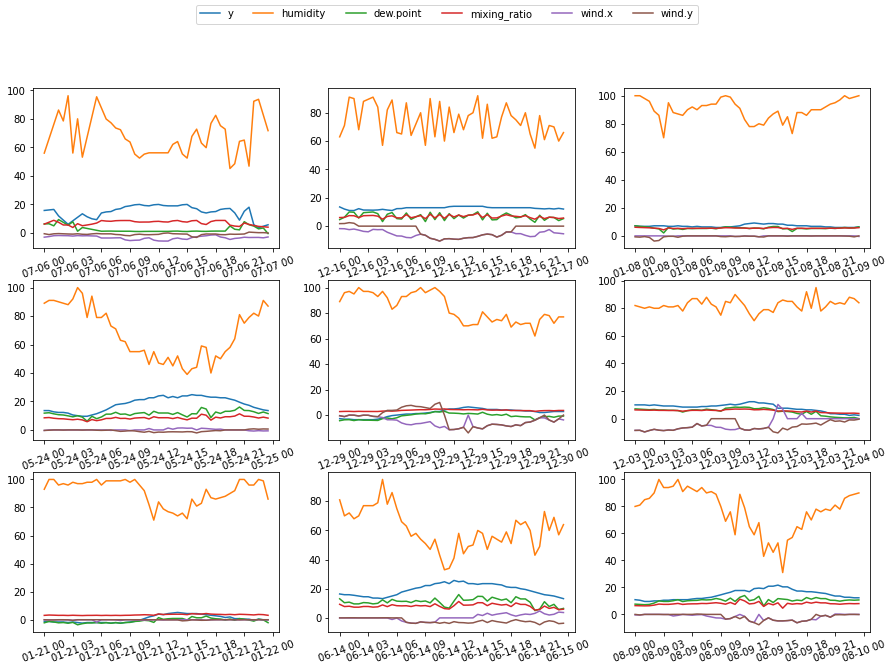

In [4]:
if 'google.colab' in str(get_ipython()):
    data_url = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/CamMetCleanishMissAnnotated2022.09.20.csv?raw=true"
else:
    data_url = "../data/CamMetCleanishMissAnnotated2022.09.20.csv"

df = pd.read_csv(data_url, parse_dates=['ds'])
df.set_index('ds', drop=False, inplace=True)
df = df[~df.index.duplicated(keep='first')]
df = df.asfreq(freq='30min')
df_orig = df


# Data reformating - https://www.cl.cam.ac.uk/research/dtg/weather/weather-raw-format.txt
for column in ['temperature', 'dew.point', 'wind.speed.mean']:
    df[column] /= 10

df['y'] = df['temperature']
    
# Deep copy avoids SettingWithCopyWarning
df = df.loc['2008-08-01 00:00:00':'2022-09-19 00:00:00', :].copy(deep=True)


# Convert wind direction and speed to x and y vectors, so the model can more easily interpret them.
wv = df['wind.speed.mean']
wd_rad = df['wind.bearing.mean'] * np.pi / 180  # Convert to radians

# Calculate the wind x and y components
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)


# From https://carnotcycle.wordpress.com/2012/08/04/how-to-convert-relative-humidity-to-absolute-humidity/
# Neither ah (absolute humidity) nor rh (relative humidity) proved useful for 
# forecasting but they may have utility for imputation
# See also: https://carnotcycle.wordpress.com/2017/08/01/compute-dewpoint-temperature-from-rh-t/
#           https://carnotcycle.wordpress.com/tag/formula/
#df['rh'] = 100 * (np.exp((18.678 * df['dew.point']) / (257.14 + df['dew.point'])) / np.exp((18.678 * df['y']) / (257.14 + df['y'])))
#df.loc[df['rh'] > 100.0, 'rh'] = 100.0
#df.loc[df['rh'] <  20.0, 'rh'] =  20.0
df['ah'] = 13.24715 * df['humidity'] * (np.exp((17.67 * df['y']) / (243.5 + df['y']))) / (273.15 + df['y'])
df['mixing_ratio'] = 6.112 * 6.2218 * df['humidity'] * np.exp(17.67 * df['y'] / (df['y'] + 243.5)) / \
                     (df['pressure'] - 0.06112 * df['humidity'] * np.exp(17.67 * df['y'] / (df['y'] + 243.5)))


# Convert to secs and add daily and yearly sinusoidal time terms
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day  = 24 * 60 * 60
year = 365.2425 * day


def sinusoidal_arg(timestamp_s, denominator):
    return 2 * np.pi * timestamp_s / denominator


# df['day.sin']    = np.sin(sinusoidal_arg(timestamp_s, 1 * day))
# df['day.cos']    = np.cos(sinusoidal_arg(timestamp_s, 1 * day))
# df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))

for i in [1, 2, 3]:
    df['day.sin.'  + str(i)] = np.sin(sinusoidal_arg(timestamp_s, i * day))
    df['day.cos.'  + str(i)] = np.cos(sinusoidal_arg(timestamp_s, i * day))
    df['year.sin.' + str(i)] = np.sin(sinusoidal_arg(timestamp_s, i * year))
    df['year.cos.' + str(i)] = np.cos(sinusoidal_arg(timestamp_s, i * year))


# Add daily spline-based time terms
from sklearn.preprocessing import SplineTransformer


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree  = degree,
        n_knots = n_knots,
        knots   = np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation = "periodic",
        include_bias  = True,
    )


daily_obs = 48
hour_df = pd.DataFrame(
    np.linspace(0, day, daily_obs + 1).reshape(-1, 1),
    columns=["secs"],
)

yearly_obs = int(365.2425 * daily_obs)  # annual observations
month_df = pd.DataFrame(
    np.linspace(0, year, yearly_obs + 1).reshape(-1, 1),
    columns=["secs"],
)

# 12 splines approximating 12 month-like time components
day_splines = periodic_spline_transformer(day, n_splines=12).fit_transform(hour_df)
day_splines_df = pd.DataFrame(
    day_splines,
    columns=[f"day_spline_{i}" for i in range(day_splines.shape[1])],
)
day_secs_step = int(day / daily_obs)
day_splines_df['secs_since_midnight'] = range(0, day + day_secs_step, day_secs_step)

# pd.concat([hour_df, day_splines_df], axis="columns").plot(x="secs", cmap=plt.cm.tab20b)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

year_splines = periodic_spline_transformer(year, n_splines=12).fit_transform(month_df)
year_splines_df = pd.DataFrame(
    year_splines,
    columns=[f"year_spline_{i}" for i in range(year_splines.shape[1])],
)
year_splines_df['secs_elapsed'] = range(0, int(year), day_secs_step)



# Add seasonal mean temperature 'y_seasonal'
df['secs_since_midnight'] = ((df['ds'] - df['ds'].dt.normalize()) / pd.Timedelta('1 second')).astype(int)
df['doy'] = df['ds'].apply(lambda x: x.dayofyear - 1)
df['secs_elapsed'] = df['secs_since_midnight'] + df['doy'] * day

df_seasonal_y = df[['y', 'secs_elapsed']].groupby('secs_elapsed').mean('y')
df_seasonal_y.rename(columns={'y': 'y_seasonal'}, inplace=True)

df = pd.merge(df, df_seasonal_y,   on='secs_elapsed')
df = pd.merge(df, day_splines_df,  on='secs_since_midnight')
df = pd.merge(df, year_splines_df, on='secs_elapsed')

# Deseasonalise y
df['y_des'] = df['y'] - df['y_seasonal']
# df['dew.point_des'] = df['dew.point'] - df['dew.point_seasonal']


# humidity = sm.nonparametric.lowess(df['humidity'], df['secs_elapsed'], frac = 0.05)
# df['humidity_smoothed'] = humidity[:, 1]
# Smooth humidity by taking the moving average
# df['humidity_smoothed'] = df['humidity'].rolling(4).mean()
#df['humidity'].corr(df['humidity_smoothed']) 
#0.7631722828054265 (rolling(6))
#0.789564437598209  (rolling(4))


# Add Boruta-style "shadow" variables for feature selection
for var in ['y_des', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y']:
    df[var + '_shadow'] = np.random.permutation(df[var])

# Add absolute values for variables which can be negative
#for var in ['y_des', 'dew.point', 'wind.x', 'wind.y']:
#    df[var + '_abs'] = abs(df[var])

# Add squared values for the main variables
for var in ['y_des', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y']:
    df[var + '_square'] = df[var] ** 2

# Add copies of variables! - EXPERIMENTAL DEBUG
for var in ['y_des', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y']:
    df[var + '_copy'] = df[var]


# 2 main terms from here https://earthscience.stackexchange.com/questions/14899/how-can-temperature-be-calculated-given-relative-humidity-and-dew-point
#df['humidity']  = np.log(df['humidity'] / 100.)
#df['dew.point'] = 17.625 * df['dew.point'] / (243.04 + df['dew.point'])


df.set_index('ds', drop=False, inplace=True)
df = df.asfreq(freq='30min')


# Reorder and drop temporary calculation columns
cols = ['ds', 'y', 'y_seasonal', 'y_des', 'humidity', 'pressure', \
        'dew.point', 'mixing_ratio', 'ah', 'wind.x', 'wind.y',  \
        'day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1', \
        #'day.sin.2', 'day.cos.2', 'year.sin.2', 'year.cos.2', \
        #'day.sin.3', 'day.cos.3', 'year.sin.3', 'year.cos.3', \
        'y_des_shadow', 'humidity_shadow', 'pressure_shadow', \
        'dew.point_shadow', 'wind.x_shadow', 'wind.y_shadow', \
        #'y_des_abs', 'dew.point_abs', 'wind.x_abs', 'wind.y_abs', \
        #'y_des_square', 'humidity_square', 'pressure_square', \
        #'dew.point_square', 'wind.x_square', 'wind.y_square', \
        #'y_des_copy', 'humidity_copy', 'pressure_copy', \
        #'dew.point_copy', 'wind.x_copy', 'wind.y_copy', \
        #'day_spline_0', 'day_spline_1', 'day_spline_2', 'day_spline_3', \
        #'day_spline_4', 'day_spline_5',  'day_spline_6', 'day_spline_7', \
        #'day_spline_8', 'day_spline_9', 'day_spline_10', 'day_spline_11', \
        #'year_spline_0', 'year_spline_1', 'year_spline_2', 'year_spline_3', \
        #'year_spline_4', 'year_spline_5',  'year_spline_6', 'year_spline_7', \
        #'year_spline_8', 'year_spline_9', 'year_spline_10', 'year_spline_11', \
        'missing', 'known_inaccuracy', 'isd_outlier', 'long_run', 'spike', \
        'cooksd_out', 'isd_3_sigma', 'isd_filled', 'hist_average', \
        'mi_filled', 'mi_spike_interp', 'lin_interp']
df = df[cols]


# For use in other notebooks
if not 'google.colab' in str(get_ipython()):
    data_loc = "../data/CamMetPrepped2022.09.20.csv"
    df.to_csv(data_loc)


print("Shape:")
display(df.shape)
print("\nInfo:")
display(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
display(df)
print("\n")


def plot_observation_examples(data, cols):
    """Plot 9 sets of observations in 3 * 3 matrix"""

    assert len(data) == 9

    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(9):
        for col in cols:
            axs[i].plot(data[i]['ds'], data[i][col])
            axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)
    
    fig.legend(cols, loc = 'upper center',  ncol = len(cols))
    
    return None


num_plots = 9
days = df.ds.dt.date.sample(n = num_plots).sort_values()
p_data = [df[df.ds.dt.date.eq(days[i])] for i in range(num_plots)]
cols   = ['y', 'humidity', 'dew.point', 'mixing_ratio', 'wind.x', 'wind.y']  # 'pressure',    

plot_observation_examples(p_data, cols)

Didn't include pressure in example observation plots because those values are an order of magnitude higher than the other features. Didn't include absolute humidity (ah) in example observation plots because the plots become very cluttered.

#### Calculate solar irradiance

[Solar irradiance](https://en.wikipedia.org/wiki/Solar_irradiance) is the power per unit area (surface power density) received from the Sun. Irradiance plays a part in weather forecasting. I calculate solar irradiance for Cambridge using the python [solarpy](https://github.com/aqreed/solarpy) module. I suspect forecasts could be substantially improved if solar irradiance could be combined with a measure of cloud cover.  It could also be used as a future covariate with models built with the darts package.

Solar irradiance calculation:
 * takes approx. 1 min to run on full data set
 * don't need to run for full data set as I do here

In [5]:
import sys
import subprocess
import pkg_resources


required  = {'solarpy'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing   = required - installed
# print("missing:", missing)

# if missing:
if missing == required:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing])  #, stdout=subprocess.DEVNULL)


from solarpy import irradiance_on_plane


h = 6  # height above sea level
lat = 52.210922
vnorm = np.array([0, 0, -1])  # plane pointing zenith
irradiances = list()

print("Calculating irradiance:", sep=' ')
for d in tqdm(df.index):
    irradiance = irradiance_on_plane(vnorm, h, d, lat)
    irradiances.append(irradiance)

df['irradiance'] = irradiances

Calculating irradiance:


100%|██████████| 247777/247777 [01:16<00:00, 3240.75it/s]


**TODO** Run irradiance calculation for single year then repeat values across whole data set.

---

### Split data¶

I use data from 2018 for validation, 2019 for testing and the remaining data for training. These are entirely arbitrary choices. This results in an approximate 84%, 8%, 8% split for the training, validation, and test sets respectively.

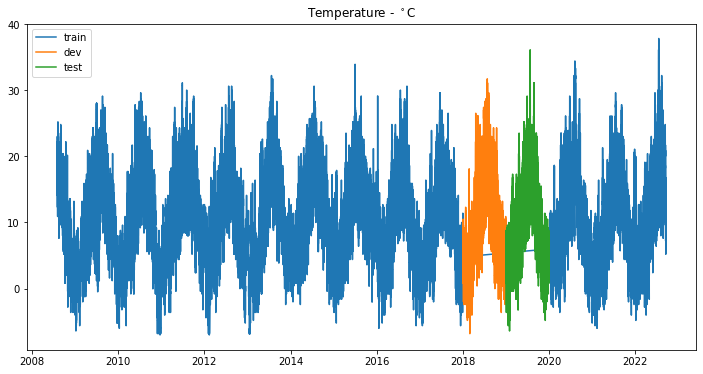

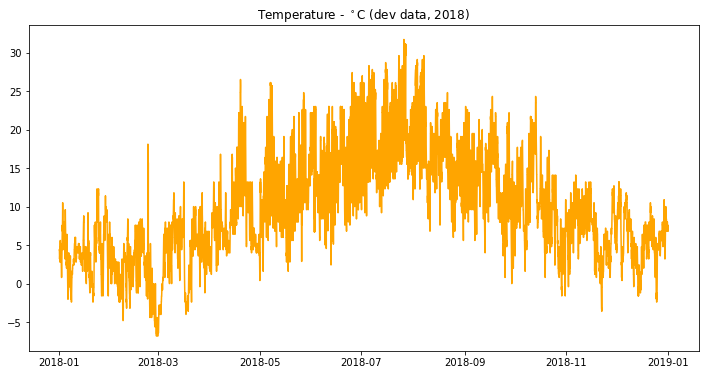

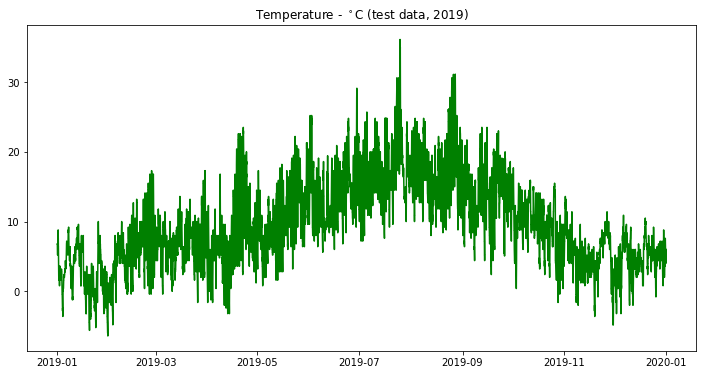

df.drop shape:  (247777, 34)
train shape:    (247777, 34)
valid shape:    (17520, 34)
test shape:     (17520, 34)


In [6]:
# keep_cols = ['ds', 'y', 'y_seasonal', 'y_des', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y', \
#              'day.sin', 'day.cos', 'year.sin', 'year.cos', 'missing', 'known_inaccuracy', \
#              'isd_outlier', 'long_run', 'spike', 'cooksd_out', 'isd_3_sigma', \
#              'isd_filled', 'hist_average', 'mi_filled', 'mi_spike_interp', 'lin_interp']

df['year'] = df['ds'].dt.year
train_df = df.loc[(df['year'] != 2018) & (df['year'] != 2019)]
#train_df = df.loc[(df['year'] == 2015) | (df['year'] == 2016) | (df['year'] == 2017)]
valid_df = df.loc[df['year'] == 2018]
test_df  = df.loc[df['year'] == 2019]


plt.figure(figsize = (12, 6))
plt.plot(train_df.ds, train_df.y)
plt.plot(valid_df.ds, valid_df.y)
plt.plot(test_df.ds,  test_df.y)
plt.title('Temperature - $^\circ$C')
plt.legend(['train', 'dev', 'test'])
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(valid_df.ds, valid_df.y, color='orange')
plt.title('Temperature - $^\circ$C (dev data, 2018)')
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(test_df.ds, test_df.y, color='green')
plt.title('Temperature - $^\circ$C (test data, 2019)')
plt.show()


del_cols = ['year']
train_df = train_df.drop(del_cols, axis = 1)
valid_df = valid_df.drop(del_cols, axis = 1)
test_df  = test_df.drop(del_cols,  axis = 1)
df = df.drop(['year'], axis = 1)

train_df = train_df.asfreq(freq='30min', method='ffill')
valid_df = valid_df.asfreq(freq='30min', method='ffill')
test_df  =  test_df.asfreq(freq='30min', method='ffill')


print("df.drop shape: ", df.shape)
print("train shape:   ", train_df.shape)
print("valid shape:   ", valid_df.shape)
print("test shape:    ", test_df.shape)


---


### tsfresh Feature Engineering and Selection

tsfresh is a python package which automatically calculates a large number of time series characteristics.  The package contains methods to evaluate the explaining power and importance of these characteristics.  There is a list of characteristics [here](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).

 * pros
   * produces many potentially useful features
 * cons
   * fairly basic feature selection
   * can be quite slow to run
   * quite a few redundant features
   * unsure about the window lengths to use for calculating features
     * starting with daily period (48) and multiples thereof (96)

Calculate features for the following variables:
 * y_des, humidity, pressure, dew.point, wind.x, wind.y

My general approach is:
 1. run automated feature engineering on data subset
 2. perform feature selection on data subset
 3. remove redundant features
 4. calculate selected features for full data set

I will repeat this 2 or 3 times:
 1. for every individual observation
 2. for every sequence of 48ish observations
    * 48, 49 or 50
 3. for every sequence of 96ish observations
    * 96, 97, 98, 99, 100

A few brief notes on data leakage:
  * should be no data leakage when calculating features for every individual observation
    * but potentially a lot of redundant features
  * for the 48ish and/or 96ish observation sequences
    * first extract features on a subset of the training set
    * select features on a subset of the training set
    * then extract selected features on
      * full training data
      * validation data
      * testing data
  * see docs [here](https://tsfresh.readthedocs.io/en/latest/text/forecasting.html) and example notebook [here](https://github.com/blue-yonder/tsfresh/blob/main/notebooks/examples/05%20Timeseries%20Forecasting.ipynb)

---

But first plot ACF and PACF to help decide values for `max_time_shift` parameter:

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


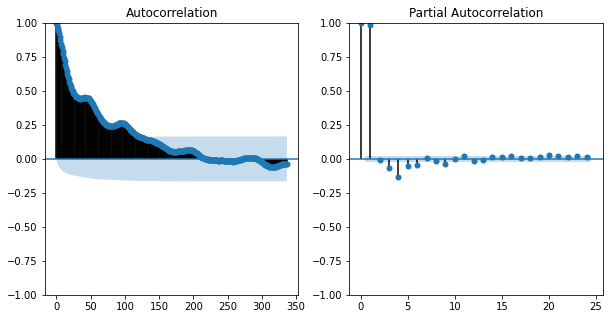

In [ ]:
import statsmodels.api as sm


n = 7000
ycol = 'y_des'
max_lag = 336

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sm.graphics.tsa.plot_acf(df[ycol].head(n),  lags=max_lag, ax=ax[0])
sm.graphics.tsa.plot_pacf(df[ycol].head(n), lags=24, ax=ax[1])
plt.show()

The ACF and PACF plots show:
 * First decline around 36
 * First peak around 48
 * Second decline around 72
 * Second peak around 96
 * Final decline around 144

Try `max_time_shift` equal to 50 (48-ish) then 100 (96-ish).

---

Now, imports from tsfresh:

In [7]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.feature_extraction import settings

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE



### 1. Generate features for individual observations

A few things to note about tsfresh feature engineering with this data set:
  * unfortunately calculating all features for the full data set would take too long
    * stopped process when eta exceeded 10 hours
    * so calculate and select features from 1 year of data 
      * even using just 2 years of data crashed colab due to out of memory problems :-(
    * then extract selected features for full data set
    * ended up using `tsfresh.settings.EfficientFCParameters` which calculates a faster subset of features
  * we don't need the `roll_time_series` function with individual observations
    * see the [05 Timeseries Forecasting](https://github.com/blue-yonder/tsfresh/blob/main/notebooks/examples/05%20Timeseries%20Forecasting.ipynb) example notebook for details if interested

Feature extraction is documented [here](https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html).

First, run automated feature engineering:


In [8]:
# approx 35 mins

df.dropna(inplace=True)
df.loc[:, 'id'] = range(1, len(df) + 1)
df.loc[:, 'datestamp'] = df['ds']

settings_efficient = settings.EfficientFCParameters()

# n =  1000     #  1:19
# n = 10000     # 16 mins
# n = 365 * 48  # 22 mins but crashed at end of run :-(
n = 15000       # 20 mins

cols = ['id', 'datestamp', 'y_des', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y']
df_features = extract_features(df.loc[:, cols].head(n), 
                               column_id       = "id", 
                               column_sort     = "datestamp",
                               impute_function = impute,
                               default_fc_parameters = settings_efficient)

print("df_features:", df_features.shape)

Feature Extraction: 100%|██████████| 10/10 [27:54<00:00, 167.47s/it]


df_features: (15000, 4728)


The initial set of features includes 4,728!

tsfresh feature filtering is documented [here](https://tsfresh.readthedocs.io/en/latest/text/feature_filtering.html).

Second, perform feature selection:

In [9]:
df_target = df['y_des'].head(n)
df_target.index = range(1, len(df_target) + 1)

print("df_features:", df_features.shape)
print("df_target: ",  df_target.shape)

X_filtered = select_features(df_features, df_target)
print("X_filtered:", X_filtered.shape)

relevance_table = calculate_relevance_table(X_filtered, df_target)
relevance_table = relevance_table[relevance_table.relevant]
relevance_table.sort_values("p_value", inplace=True)
print(relevance_table.loc[:, ['feature', 'p_value']])

df_features: (15000, 4728)
df_target:  (15000,)
X_filtered: (15000, 163)
                                                                                              feature  \
feature                                                                                                 
y_des__sum_values                                                                   y_des__sum_values   
dew.point__cwt_coefficients__coeff_0__w_5__widt...  dew.point__cwt_coefficients__coeff_0__w_5__wid...   
dew.point__maximum                                                                 dew.point__maximum   
dew.point__absolute_maximum                                               dew.point__absolute_maximum   
dew.point__root_mean_square                                               dew.point__root_mean_square   
...                                                                                               ...   
wind.y__mean                                                                           

The initial set of features has reduced from 4,728 to 163.
Briefly, a p-value is calculated for each feature and a multiple testing correction is then applied.

Third, calculate selected features for full data set:

In [14]:
# approx. 40 mins

relevant_settings = settings.from_columns(X_filtered)
print("relevant_settings:\n", 
      json.dumps(relevant_settings, sort_keys=True, indent=4))
# TODO Save relevant_settings to file and commit to repo

cols = ['id', 'datestamp', 'y_des', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y']
df_selected_features = extract_features(df.loc[:, cols], 
                                        column_id       = "id", 
                                        column_sort     = "datestamp",
                                        impute_function = impute,
                                        kind_to_fc_parameters = relevant_settings)

df_selected_features['ds'] = df.index
df_selected_features_orig  = df_selected_features
print("df_selected_features:", df_selected_features.shape)

relevant_settings:
 {
    "dew.point": {
        "abs_energy": null,
        "absolute_maximum": null,
        "benford_correlation": null,
        "count_above": [
            {
                "t": 0
            }
        ],
        "count_below": [
            {
                "t": 0
            }
        ],
        "cwt_coefficients": [
            {
                "coeff": 0,
                "w": 2,
                "widths": [
                    2,
                    5,
                    10,
                    20
                ]
            },
            {
                "coeff": 0,
                "w": 10,
                "widths": [
                    2,
                    5,
                    10,
                    20
                ]
            },
            {
                "coeff": 0,
                "w": 20,
                "widths": [
                    2,
                    5,
                    10,
                    20
                ]
         

Feature Extraction: 100%|██████████| 10/10 [38:34<00:00, 231.47s/it]


df_selected_features: (247633, 164)


Remove redundant features:

In [15]:
df_selected_features.set_index('ds', drop=False, inplace=True)
df_selected_features = df_selected_features.asfreq(freq='30min')

print("df_selected_features:")
print(df_selected_features.info())
print(df_selected_features.columns, "\n")
print("df:")
print(df.info(), "\n")

#cols = ['ds', 'y', 'y_seasonal', 'y_des', 'humidity', 'pressure', \
#        'dew.point', 'wind.x', 'wind.y', 'mixing_ratio', 'ah', 'irradiance', \
#        'day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1', \
#        'y_des_shadow', 'humidity_shadow', 'pressure_shadow', \
#        'dew.point_shadow', 'wind.x_shadow', 'wind.y_shadow', \
#        'missing', 'known_inaccuracy', 'isd_outlier', 'long_run', 'spike', \
#        'cooksd_out', 'isd_3_sigma', 'isd_filled', 'hist_average', \
#        'mi_filled', 'mi_spike_interp', 'lin_interp']
keep_cols = ['y_des', 'humidity', 'pressure', 'dew.point', \
             'wind.x', 'wind.y', 'ah', 'mixing_ratio', 'irradiance']
df_red = pd.merge(df[keep_cols], df_selected_features, left_index=True, right_index=True)  # red - redundant

df_red.set_index('ds', drop=False, inplace=True)
df_red = df_red[~df_red.index.duplicated(keep='first')]
df_red = df_red.asfreq(freq='30min')
print("df_red:")
print(df_red.info())

# Create correlation matrix
corr_matrix = df_red.corr().abs()
# print("corr_matrix:", corr_matrix, sep='\n')

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# print("upper:", upper, sep='\n')

# Find index of feature columns with correlation greater than corr_cutoff
corr_limit = 0.95
to_drop = [column for column in upper.columns if any(upper[column] > corr_limit)]
to_drop = [column for column in to_drop if column not in keep_cols]
print("to_drop:")
print(to_drop)
print(len(to_drop))

# Drop features 
df_nr = df_selected_features.drop(to_drop, axis=1)  # nr - non-redundant
df_nr_orig = df_nr
print("\ndf_nr:", df_nr.shape)
print(df_nr.info())

df_selected_features:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247777 entries, 2008-08-01 00:00:00 to 2022-09-19 00:00:00
Freq: 30T
Columns: 164 entries, y_des__sum_values to ds
dtypes: datetime64[ns](1), float64(163)
memory usage: 311.9 MB
None
Index(['y_des__sum_values', 'y_des__range_count__max_1__min_-1',
       'y_des__quantile__q_0.9', 'y_des__quantile__q_0.3',
       'y_des__quantile__q_0.4', 'y_des__quantile__q_0.6',
       'y_des__quantile__q_0.7', 'y_des__quantile__q_0.8',
       'y_des__quantile__q_0.2', 'y_des__quantile__q_0.1',
       ...
       'wind.y__quantile__q_0.3', 'wind.y__quantile__q_0.2',
       'wind.y__quantile__q_0.1', 'wind.y__minimum', 'wind.y__maximum',
       'wind.y__mean', 'wind.y__median', 'wind.y__sum_values',
       'wind.y__count_above__t_0', 'ds'],
      dtype='object', length=164) 

df:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247633 entries, 2008-08-01 00:00:00 to 2022-09-19 00:00:00
Data columns (total 36 columns):
 #   Co

The number of features has decreased from 163 to 29!

Finally, save the tsfresh features:

In [ ]:
fn = 'tsfresh.2022.09.20.csv.xz'
df_nr.to_csv() 


# from google.colab import files
# files.download(fn) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2. Generate features for sequences of 48ish observations

This time try rolling the time series in groups of 48ish observations.
  * ... 48, 49, 50

The [roll_time_series](https://tsfresh.readthedocs.io/en/latest/text/forecasting.html) function used to avoid data leakage substantially increases the data processed by the `extract_features` function.  I had to split the training data into 3 subsets to decrease computational time.

Similar process to generating features for individual observations:
 * generate features on subset of training data
 * select best features on subset of training data
   * I have limited it to choosing the top 100 features
 * remove redundant features on subset of training data
 * calculate non-redundant selected features
   * all train data
   * all valid data
   * all test data

This process then maps directly onto 4 functions:
 * `generate_features`
 * `select_best_features`
 * `remove_redundant_features`
 * `calculate_full_dataset_features`

In [8]:
def generate_features(df, cols, n, timeshift):

    df.loc[:, 'id'] = 'fubar'
    df.loc[:, 'datestamp'] = df['ds']

    df_rolled = roll_time_series(df.loc[:, cols].head(n), 
                                 column_id     = 'id', 
                                 column_sort   = 'datestamp',
                                 max_timeshift = timeshift, 
                                 min_timeshift = timeshift)
    print("df_rolled:", df_rolled.shape, sep='\n')

    settings_efficient = settings.EfficientFCParameters()

    df_features = extract_features(df_rolled, 
                                   column_id       = 'id', 
                                   column_sort     = 'datestamp',
                                   impute_function = impute,
                                   default_fc_parameters = settings_efficient)
    
    return df_features


def select_best_features(df, df_features, top_n_features=200, fdr_cutoff=0.00005):
    df_features = df_features.set_index(df_features.index.map(lambda x: x[1]), drop=True)
    df_features.index.name = 'ds'
    df_features = df_features[~df_features.index.duplicated(keep='first')]
    df_features = df_features.asfreq(freq='30min')

    target_cols = ['ds', 'y_des']
    df_target = pd.merge(df[target_cols], 
                         df_features, 
                         left_on  = df.index, 
                         right_on = df_features.index)[target_cols]
    df_target.set_index('ds', drop=True, inplace=True)
    df_target = df_target[~df_target.index.duplicated(keep='first')]
    df_target = df_target.asfreq(freq='30min')

    df_target.dropna(inplace=True)
    df_features.dropna(inplace=True)
    print("df_features:", df_features.shape)
    print("df_target:  ", df_target.shape)

    X_filtered = select_features(df_features, 
                                 df_target['y_des'], 
                                 fdr_level=fdr_cutoff)

    relevance_table = calculate_relevance_table(X_filtered, df_target['y_des'])
    relevance_table = relevance_table[relevance_table.relevant]
    relevance_table.sort_values("p_value", inplace=True)

    if top_n_features < len(relevance_table):
        relevance_table = relevance_table[:top_n_features]

    keep_features   = relevance_table['feature']
    X_filtered      = X_filtered.loc[:, keep_features]

    return X_filtered, relevance_table


def remove_redundant_features(df, df_filtered, keep_cols, corr_limit=0.95):

    print("df_filtered: ", df_filtered.shape)
    df_to_filter = pd.merge(df[keep_cols], 
                            df_filtered, 
                            left_on  = df.index, 
                            right_on = df_filtered.index)

    print("df_to_filter:", df_to_filter.shape)

    # Create correlation matrix
    corr_matrix = df_to_filter.corr().abs()
    # print("corr_matrix:", corr_matrix, sep='\n')

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # print("upper:", upper, sep='\n')

    # Find index of feature columns with correlation greater than corr_limit
    to_drop = [column for column in upper.columns if any(upper[column] > corr_limit)]
    to_drop = [column for column in to_drop if column not in keep_cols]
    print("to_drop:", to_drop, sep='\n')
    print(len(to_drop))

    # Drop features 
    X_nr = df_to_filter.drop(to_drop, axis=1)
    X_nr.drop(keep_cols, axis=1, inplace=True)
    X_nr.drop('key_0', axis=1, inplace=True)

    return X_nr


def roll_ts_extract_features(df, relevant_settings, timeshift):
    df_rolled = roll_time_series(df.loc[:, cols], 
                                 column_id     = 'id', 
                                 column_sort   = 'datestamp',
                                 max_timeshift = timeshift, 
                                 min_timeshift = timeshift)
    print("df_rolled:", df_rolled.shape, sep='\n')

    df_selected_features = extract_features(df_rolled, 
                                            column_id       = 'id', 
                                            column_sort     = 'datestamp',
                                            impute_function = impute,
                                            kind_to_fc_parameters = relevant_settings)
    print("df_selected_features:", df_selected_features.shape)

    return df_selected_features


def calculate_full_dataset_features(df, X_nr, cols, window, timeshift, corr_limit=0.95, dataset=None):
    relevant_settings = settings.from_columns(X_nr)
    # TODO Save to file and commit to repo
    # print("relevant_settings:\n", 
    #       json.dumps(relevant_settings, sort_keys=True, indent=4))

    df = df[~df.index.duplicated(keep='first')]
    df = df.asfreq(freq='30min')
    df.dropna(inplace=True)
    df.loc[:, 'id'] = 'fubar'
    df.loc[:, 'datestamp'] = df['ds']


    # Got to loop over larger training set in subsets because 
    # roll_time_series gets stuck somewhere above 80,000 rows.
    # Getting stuck problem could be colab or tsfresh or both.
    list_of_df = []
    if dataset == 'train' and df.shape[0] > 90000:
        subsets = 3
        subset_size = df.shape[0] // subsets

        for i in range(subsets):
            print('\ninside large train set loop:', str(i+1), 'of', subsets)
            df_min = i * subset_size
            df_max = (i + 1) * subset_size
            print("df_min df_max:", df_min, df_max)
            df_subset = df.iloc[df_min:df_max, :]
            print("df_subset:", df_subset.shape)
            df_selected_features_i = roll_ts_extract_features(df_subset, relevant_settings, timeshift)
            df_selected_features_i = df_selected_features_i.set_index(df_selected_features_i.index.map(lambda x: x[1]), drop=True)
            list_of_df.append(df_selected_features_i)

        df_selected_features = pd.concat(list_of_df)
        df_selected_features.loc[:, 'ds'] = df_selected_features.index.values
        print("df_selected_features:", df_selected_features.info(), sep='\n')
    else:
        df_selected_features = roll_ts_extract_features(df, relevant_settings, timeshift)
        df_selected_features = df_selected_features.set_index(df_selected_features.index.map(lambda x: x[1]), drop=True)

    print("df_selected_features:", df_selected_features.shape)
    df_selected_features.index.name = 'ds'
    df_selected_features = df_selected_features[~df_selected_features.index.duplicated(keep='first')]
    df_selected_features = df_selected_features.asfreq(freq='30min')

    # One more round of redundancy removal
    # train dataset only which is then used for valid and test data calculations
    # train dataset only to avoid data leakage
    if dataset == 'train':
        data_cols = [col for col in cols if col not in ('id', 'datestamp')]
        df_final = remove_redundant_features(df, df_selected_features, data_cols, corr_limit)
        df_final.set_index('ds', drop=True, inplace=True)
        df_final.index.name = 'ds'
    else:
        df_final = df_selected_features
        # Can't rename train cols yet - used for valid and test calculations
        to_re = '_' + str(window) + '_'
        df_final = df_final.rename(columns=lambda x: re.sub('__', to_re, x, 1))

    return df_final

After specifing the functions we can now run the process and create the 3 files with features:
 * **WARNING** google colab sometimes runs out of RAM and crashes when using `n = 17520  # 48 * 365`
   * if so, rerun and/or lower to `n = 10000`

In [9]:
# 5 hours 17 mins

# n  = 10000
n    = 17520  # 48 * 365
cols = ['id', 'datestamp', 'y_des', 'humidity', \
        'pressure', 'dew.point', 'wind.x', 'wind.y']
data_cols  = ['y_des', 'humidity', 'pressure', 'dew.point', \
              'wind.x', 'wind.y', 'ah', 'mixing_ratio', 'irradiance']
window     = 48
timeshift  = 50
corr_limit = 0.75

# This is the slowest part
train_df.dropna(inplace=True)
traindf_features = generate_features(train_df, cols, n, timeshift)
print("traindf_features:", traindf_features.shape)


X_filtered, relevance_table = select_best_features(train_df, traindf_features)
print("X_filtered: ", X_filtered.shape)
print(relevance_table.loc[:, ['feature', 'p_value']])
print()


X_nr = remove_redundant_features(train_df, X_filtered, data_cols, corr_limit)
print("X_nr:", X_nr.shape)
print()


ds = 'train'
train_df_final = calculate_full_dataset_features(train_df, X_nr, cols, window, timeshift, corr_limit, ds)
print("train_df_final:", train_df_final.shape, "\n")

ds = 'valid'
valid_df_final = calculate_full_dataset_features(valid_df, train_df_final, cols, window, timeshift, corr_limit, ds)
print("valid_df_final:", valid_df_final.shape, "\n")
fn = 'tsfresh_' + str(window)  + 'ish_' + ds + '.2022.09.20.csv.xz'
valid_df_final.to_csv(fn) 

ds = 'test'
test_df_final = calculate_full_dataset_features(test_df, train_df_final, cols, window, timeshift, corr_limit, ds)
print("test_df_final:", test_df_final.shape, "\n")
fn = 'tsfresh_' + str(window)  + 'ish_' + ds + '.2022.09.20.csv.xz'
test_df_final.to_csv(fn) 


# Rename train cols after valid and test calculations
to_re = '_' + str(window) + '_'
train_df_final = train_df_final.rename(columns=lambda x: re.sub('__', to_re, x, 1))

ds = 'train'
fn = 'tsfresh_' + str(window)  + 'ish_' + ds + '.2022.09.20.csv.xz'
train_df_final.to_csv(fn)

/usr/local/lib/python3.7/dist-packages/tsfresh/utilities/dataframe_functions.py:521: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  "Your time stamps are not uniformly sampled, which makes rolling "
Rolling: 100%|██████████| 10/10 [00:44<00:00,  4.42s/it]


df_rolled:
(890970, 8)


Feature Extraction: 100%|██████████| 10/10 [1:07:04<00:00, 402.48s/it]


traindf_features: (17470, 4698)
df_features: (17470, 4698)
df_target:   (17470, 1)
X_filtered:  (17470, 200)
                                                                                              feature  \
feature                                                                                                 
y_des__sum_values                                                                   y_des__sum_values   
y_des__cwt_coefficients__coeff_6__w_5__widths_(...  y_des__cwt_coefficients__coeff_6__w_5__widths_...   
y_des__cwt_coefficients__coeff_6__w_10__widths_...  y_des__cwt_coefficients__coeff_6__w_10__widths...   
y_des__cwt_coefficients__coeff_6__w_20__widths_...  y_des__cwt_coefficients__coeff_6__w_20__widths...   
y_des__change_quantiles__f_agg_"mean"__isabs_Fa...  y_des__change_quantiles__f_agg_"mean"__isabs_F...   
...                                                                                               ...   
dew.point__agg_linear_trend__attr_"intercept"__... 

/usr/local/lib/python3.7/dist-packages/tsfresh/utilities/dataframe_functions.py:521: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  "Your time stamps are not uniformly sampled, which makes rolling "
Rolling: 100%|██████████| 10/10 [49:52<00:00, 299.23s/it]


df_rolled:
(4207194, 8)


Feature Extraction: 100%|██████████| 10/10 [23:21<00:00, 140.13s/it]


df_selected_features: (82494, 55)

inside large train set loop: 2 of 3
df_min df_max: 82544 165088
df_subset: (82544, 36)


/usr/local/lib/python3.7/dist-packages/tsfresh/utilities/dataframe_functions.py:521: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  "Your time stamps are not uniformly sampled, which makes rolling "
Rolling: 100%|██████████| 10/10 [48:01<00:00, 288.11s/it]


df_rolled:
(4207194, 8)


Feature Extraction: 100%|██████████| 10/10 [23:55<00:00, 143.53s/it]


df_selected_features: (82418, 55)

inside large train set loop: 3 of 3
df_min df_max: 165088 247632
df_subset: (82544, 36)


/usr/local/lib/python3.7/dist-packages/tsfresh/utilities/dataframe_functions.py:521: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  "Your time stamps are not uniformly sampled, which makes rolling "
Rolling: 100%|██████████| 10/10 [48:48<00:00, 292.82s/it]


df_rolled:
(4207194, 8)


Feature Extraction: 100%|██████████| 10/10 [13:25<00:00, 80.55s/it]


df_selected_features: (47581, 55)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212493 entries, 2008-08-02 01:00:00 to 2022-09-18 23:30:00
Data columns (total 56 columns):
 #   Column                                                                  Non-Null Count   Dtype         
---  ------                                                                  --------------   -----         
 0   y_des__sum_values                                                       212493 non-null  float64       
 1   y_des__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)            212493 non-null  float64       
 2   y_des__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)            212493 non-null  float64       
 3   y_des__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4      212493 non-null  float64       
 4   y_des__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0      212493 non-null  float64       
 5   y_des__change_quantiles__f_agg_"mean"__isabs_False__q

Rolling: 100%|██████████| 10/10 [00:40<00:00,  4.04s/it]


df_rolled:
(890970, 8)


Feature Extraction: 100%|██████████| 10/10 [04:48<00:00, 28.80s/it]


df_selected_features: (17470, 50)
df_selected_features: (17470, 50)
valid_df_final: (17470, 50) 



Rolling: 100%|██████████| 10/10 [00:41<00:00,  4.14s/it]


df_rolled:
(890970, 8)


Feature Extraction: 100%|██████████| 10/10 [04:46<00:00, 28.64s/it]


df_selected_features: (17470, 50)
df_selected_features: (17470, 50)
test_df_final: (17470, 50) 



Finally, download data files:

In [10]:
from google.colab import files


for ds in ['train', 'valid', 'test']:
    fn = 'tsfresh_' + str(window)  + 'ish_' + ds + '.2022.09.20.csv.xz'
    files.download(fn) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


### 3. Generate features for sequences of 96ish observations

**TODO** Only going to run this if 48ish features are sufficiently useful.

This time try rolling the time series in groups of 96ish observations.
  * 96, 97, 98, 99, 100

Similar process to generating features for individual observations:
 * generate features on subset of training data
 * select best features on subset of training data
   * I have limited it to choosing the top 100 features
 * remove redundant features on subset of training data
 * calculate non-redundant selected features
   * all train data
   * all valid data
   * all test data
 
...

...

---

### Conclusion

**TODO** Compare number and type of features from:
  * individual observations
    * 29 features
  * 48ish observations
    * 20 features
  * 96ish observations?
    * ...

Unsurprisingly, many of the generated features are derived from the deseasonalised temperature `y_des`.  

In order to reduce computational time, I have limited feature selection to the top 100 features order by p-value.  This may have removed some valid features.  I've also limited the number of features at the redundancy removal stage.  The number of top features retained and the correlation coefficient threshold used at the redundancy removal stage would benefit from being fine-tuned.

Unfortunately, dependencies between the features are not considered in the tsfresh feature selection step.
Calcualting [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) could fix this problem at a much higher computational cost.  Ideally, the Shapley value feature selection would be time series aware.  Marco Cerliani's article [Boruta SHAP for Temporal Feature Selection](https://towardsdatascience.com/boruta-shap-for-temporal-feature-selection-96a7840c7713) may be helpful.

Check the [gradient_boosting](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/gradient_boosting.ipynb) notebook for results of using these new features.

Alternatives to tsfresh include:
 * [catch22](https://github.com/DynamicsAndNeuralSystems/catch22) CAnonical Time-series CHaracteristics.
   * unfortunately, no version of catch22 will install on google colab at this time :-(
 * [Rob Hyndman's](https://robjhyndman.com/) [tsfeatures](https://cran.r-project.org/web/packages/tsfeatures/vignettes/tsfeatures.html)
   * which has been [ported to python](https://github.com/Nixtla/tsfeatures) and currently installs cleanly on colab
   * there are 22 **types** of features implemented
   * and approx. [42 features](https://htmlpreview.github.io/?https://github.com/robjhyndman/M4metalearning/blob/master/docs/M4_methodology.html#features)
 * [TSFEL](https://tsfel.readthedocs.io/en/latest/) Python package for feature extraction on time series data
   * over 60 statistical, temporal and spectral features
   * currently installs cleanly on colab
 * Table 1 from [this paper](https://arxiv.org/pdf/2011.10545.pdf) has additional suggestions which I have not explored

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/bin/python3
3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

IPython version:
7.9.0


In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


name,version
tsfresh,0.19.0
seaborn,0.11.2
scikit-learn,1.0.2
pandas,1.3.5
numpy,1.21.6
matplotlib,3.2.2
google,2.0.3


In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           AuthenticAMD
CPU family:          23
Model:               49
Model name:          AMD EPYC 7B12
Stepping:            0
CPU MHz:             2249.998
BogoMIPS:            4499.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            512K
L3 cache:            16384K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a misalignss

In [ ]:
!date

Wed Oct 26 21:14:21 UTC 2022


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "gradient_boosting.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}